In [4]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import jovian

<IPython.core.display.Javascript object>

In [5]:
dataset = MNIST(root='data/', download=True, train=True, transform=transforms.ToTensor())

In [6]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


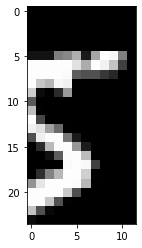

In [7]:
plt.imshow(img_tensor[0, 0:24, 13:25], cmap='gray') #needs 1st part as 0, channel not expected by imshow or is the last dimension

In [8]:
train_ds, val_ds = random_split(dataset, [50000, 10000])

batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size, shuffle=True)

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
input_size = 28*28
num_classes = 10

class MnistModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        #output layer
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, xb):
        xb = xb.reshape(-1, input_size)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
         images, labels = batch
         out = self(images)
         loss = F.cross_entropy(out, labels)
         acc = accuracy(out, labels)
         return {"val_loss": loss, "val_acc": acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accuracies = [x['val_acc'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracies).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_accuracy.item()}
    
    def epoch_end(self, epoch, result):
        print('Epoch {0}: Validation Loss: {1}, Validation Accuracy: {2}'.format(epoch, result['val_loss'], result['val_acc'])) 

In [11]:
def evaluate(model, val_loader):
    val_outs = [model.validation_step(val_batch) for val_batch in val_loader]
    val_result = model.validation_epoch_end(val_outs)
    return val_result

In [12]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = []
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        val_result = evaluate(model, val_loader)
        model.epoch_end(epoch, val_result)
        history.append(val_result)
    return history

In [18]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

device(type='cpu')

In [20]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [21]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

model = MnistModel(input_size=input_size, hidden_size=hidden_size, output_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [23]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [27]:
history1 = fit(5, 0.5, model, train_loader, val_loader)

Epoch 0: Validation Loss: 0.2528749406337738, Validation Accuracy: 0.9213805198669434
Epoch 1: Validation Loss: 0.1797156184911728, Validation Accuracy: 0.9473892450332642
Epoch 2: Validation Loss: 0.1490522027015686, Validation Accuracy: 0.9554983973503113
Epoch 3: Validation Loss: 0.14680039882659912, Validation Accuracy: 0.9552017450332642
Epoch 4: Validation Loss: 0.1475127637386322, Validation Accuracy: 0.9550039768218994


In [29]:
history2 = fit(5, 0.1, model, train_loader, val_loader)

Epoch 0: Validation Loss: 0.11937667429447174, Validation Accuracy: 0.9644976258277893
Epoch 1: Validation Loss: 0.1193532943725586, Validation Accuracy: 0.9647942781448364
Epoch 2: Validation Loss: 0.1172950342297554, Validation Accuracy: 0.9660798907279968
Epoch 3: Validation Loss: 0.11709394305944443, Validation Accuracy: 0.9648932218551636
Epoch 4: Validation Loss: 0.1204320415854454, Validation Accuracy: 0.9637064933776855


In [31]:
history = history1+history2

Text(0.5, 1.0, 'Loss vs. No. of epochs')

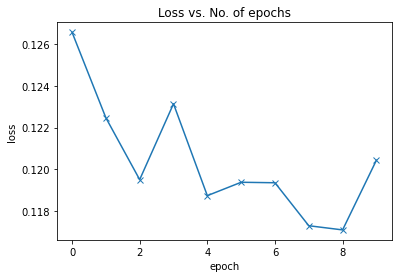

In [33]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')

In [36]:
def predict(image, model=model):
    xb = image.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [37]:
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Label: 7 , Predicted: 7


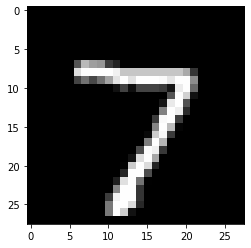

In [38]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict(img, model))

In [65]:
jovian.commit(filename='logistic_regression.ipynb',  project='pytorch_learn', git_commit=True, git_message='logistic regression final')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "nempickaxe/pytorch-learn" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Error: Failed to read Anaconda environment using command: "conda env export -n base --no-builds"
[jovian] Committed successfully! https://jovian.ml/nempickaxe/pytorch-learn


'https://jovian.ml/nempickaxe/pytorch-learn'